In [1]:
import pandas as pd

df = pd.read_csv("tox21.csv")
df.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


In [2]:
df_valid = df.dropna()
df_valid = df_valid.drop(columns=["smiles", "mol_id"])
print(f"Length of df = {len(df_valid)}")

df_overview = pd.DataFrame()
df_overview["#toxic"] = df_valid.sum().to_frame().astype("float32")
df_overview["% over df"] = df_overview["#toxic"]/len(df_valid)*100
df_overview

Length of df = 3079


,#toxic,% over df
NR-AR,59.0,1.916207
NR-AR-LBD,34.0,1.104255
NR-AhR,154.0,5.001624
NR-Aromatase,55.0,1.786294
NR-ER,244.0,7.924651
NR-ER-LBD,67.0,2.176031
NR-PPAR-gamma,26.0,0.844430
SR-ARE,196.0,6.365703
SR-ATAD5,11.0,0.357259
SR-HSE,50.0,1.623904


In [3]:
import numpy as np
        
def load_features_target() -> tuple:
    X = np.load("features.npy")
    y = np.load("labels.npy")
    return X, y

In [23]:
from tqdm import tqdm
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

class ToxicityNN(nn.Module):
    def __init__(self, input_dim=2048):
        super(ToxicityNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

def train_NN(epochs=20, batch_size=64, lr=1e-3, verbose=False):
    """
    Train and evaluate the Neural Network model.
    """

    print("Training NN...")
    X, y = load_features_target()
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train)
    y_train_tensor = torch.tensor(y_train).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test)
    y_test_tensor = torch.tensor(y_test).unsqueeze(1)

    # Data loaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Model, loss, optimizer
    model = ToxicityNN(input_dim=X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        if verbose:
            print(f"Epoch {epoch+1} loss: {epoch_loss/len(train_loader):.4f}")

    model.eval()
    with torch.no_grad():
        probs = model(X_test_tensor).numpy().flatten()
        y_pred = (probs > 0.03).astype(int)

        print("Classification report:")
        print(f"\n{classification_report(y_test, y_pred)}")
        print(f"ROC-AUC score: {roc_auc_score(y_true=y_test, y_score=probs):.2f}")

    return y_test, probs

In [24]:
y_test, probs = train_NN(verbose=True)

Training NN...


Epoch 1/20:   0%|          | 0/73 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 73/73 [00:00<00:00, 101.43it/s]


Epoch 1 loss: 0.4300


Epoch 2/20: 100%|██████████| 73/73 [00:00<00:00, 102.08it/s]


Epoch 2 loss: 0.2917


Epoch 3/20: 100%|██████████| 73/73 [00:00<00:00, 110.82it/s]


Epoch 3 loss: 0.2069


Epoch 4/20: 100%|██████████| 73/73 [00:00<00:00, 111.19it/s]


Epoch 4 loss: 0.1392


Epoch 5/20: 100%|██████████| 73/73 [00:00<00:00, 111.30it/s]


Epoch 5 loss: 0.0912


Epoch 6/20: 100%|██████████| 73/73 [00:00<00:00, 101.57it/s]


Epoch 6 loss: 0.0546


Epoch 7/20: 100%|██████████| 73/73 [00:00<00:00, 111.31it/s]


Epoch 7 loss: 0.0455


Epoch 8/20: 100%|██████████| 73/73 [00:00<00:00, 88.79it/s]


Epoch 8 loss: 0.0343


Epoch 9/20: 100%|██████████| 73/73 [00:00<00:00, 95.70it/s]


Epoch 9 loss: 0.0234


Epoch 10/20: 100%|██████████| 73/73 [00:00<00:00, 109.87it/s]


Epoch 10 loss: 0.0231


Epoch 11/20: 100%|██████████| 73/73 [00:00<00:00, 109.86it/s]


Epoch 11 loss: 0.0223


Epoch 12/20: 100%|██████████| 73/73 [00:00<00:00, 109.34it/s]


Epoch 12 loss: 0.0362


Epoch 13/20: 100%|██████████| 73/73 [00:00<00:00, 110.15it/s]


Epoch 13 loss: 0.0378


Epoch 14/20: 100%|██████████| 73/73 [00:00<00:00, 113.16it/s]


Epoch 14 loss: 0.0153


Epoch 15/20: 100%|██████████| 73/73 [00:00<00:00, 111.83it/s]


Epoch 15 loss: 0.0149


Epoch 16/20: 100%|██████████| 73/73 [00:00<00:00, 111.96it/s]


Epoch 16 loss: 0.0075


Epoch 17/20: 100%|██████████| 73/73 [00:00<00:00, 109.05it/s]


Epoch 17 loss: 0.0083


Epoch 18/20: 100%|██████████| 73/73 [00:00<00:00, 104.71it/s]


Epoch 18 loss: 0.0101


Epoch 19/20: 100%|██████████| 73/73 [00:00<00:00, 111.76it/s]


Epoch 19 loss: 0.0075


Epoch 20/20: 100%|██████████| 73/73 [00:00<00:00, 101.74it/s]

Epoch 20 loss: 0.0105
Classification report:

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       985
         1.0       0.49      0.68      0.57       176

    accuracy                           0.85      1161
   macro avg       0.72      0.78      0.74      1161
weighted avg       0.87      0.85      0.86      1161

ROC-AUC score: 0.84


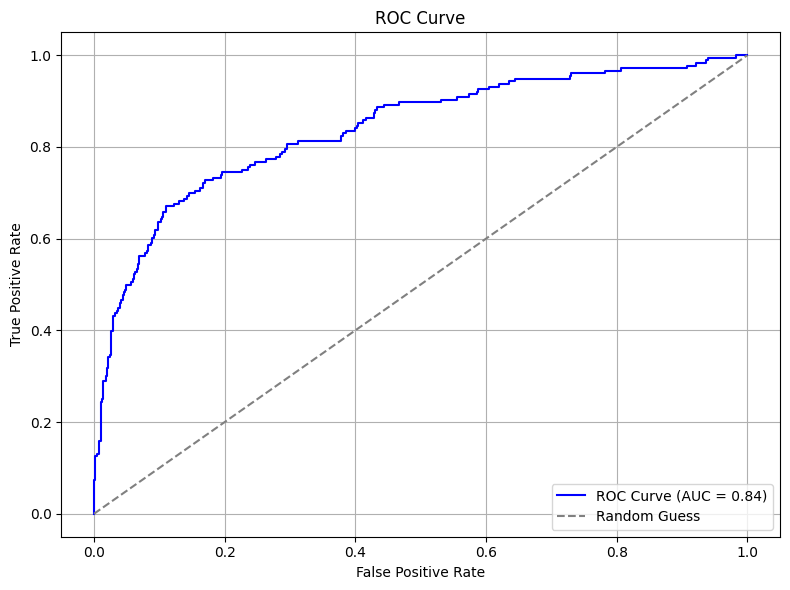

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# y_true: actual binary labels (0 or 1)
# y_probs: predicted probabilities (not predicted labels)

# Compute FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Compute AUC
auc = roc_auc_score(y_test, probs)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


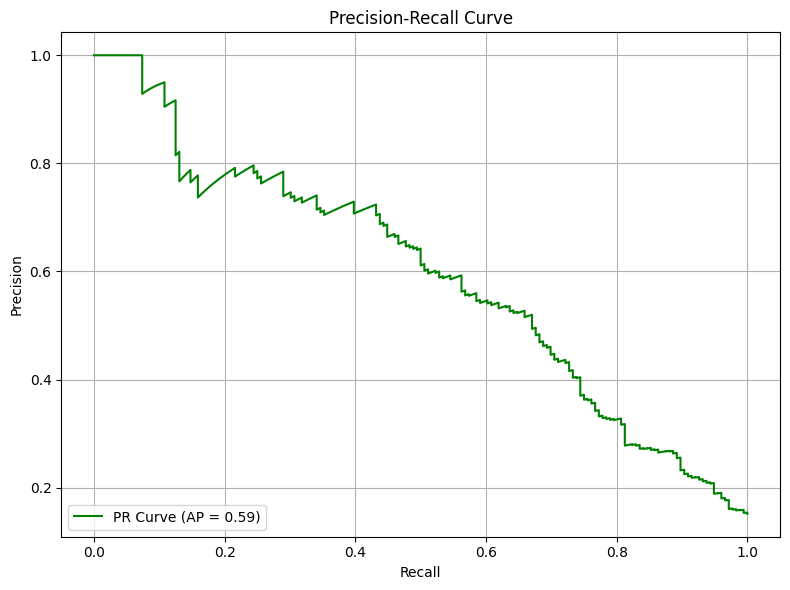

In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)

# Compute average precision (area under PR curve)
avg_precision = average_precision_score(y_test, probs)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

precision, recall, thresholds = precision_recall_curve(y_test, probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold = {best_threshold:.2f}")
print(f"Best F1-score  = {best_f1:.4f}")

Best threshold = 0.03
Best F1-score  = 0.5859


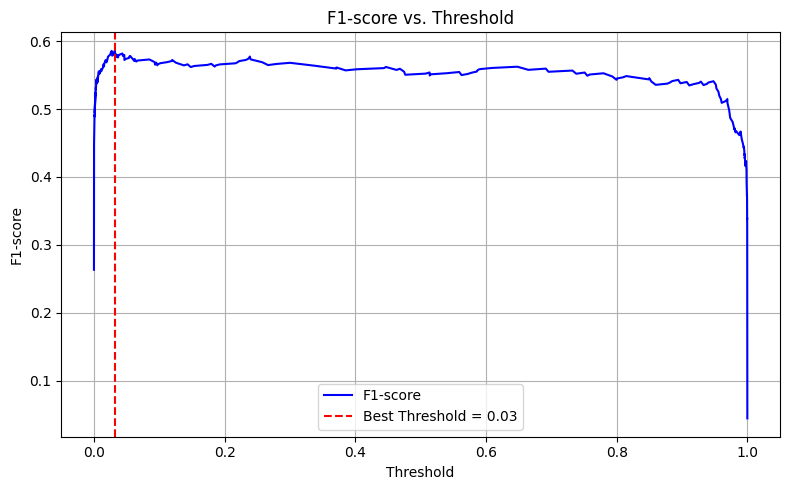

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1-score', color='blue')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()